In [ ]:
#  WMAZE Beta Series Correlation Analysis

## Obtains correlation values for the regions of interest:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC (FS labels: rostral anterior cingulate [1026,1014] & medial orbitofrontal [2026,2155])
### Dorsolateral PFC (Lausanne atlas: dlPFC)

In [ ]:
import nipype.pipeline as pe
import nipype.interfaces.io as nio
import os
import nipype.interfaces.freesurfer as fs
from nipype import IdentityInterface

subjects_dir = '/home/data/madlab/surfaces/wmaze'
work_dir = '/scratch/madlab/wmaze/regions_workdir'
sink_dir = '/home/data/madlab/data/mri/wmaze/roi_analysis/mask'

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021', 
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

wf = pe.Workflow(name = 'wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(IdentityInterface(fields = ['subject_id'], 
                                          mandatory_inputs = True),
                        name = 'subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

info = dict(ref_epi_file = [['subject_id']],
            bbreg_xfm = [['subject_id']],
            aparc_aseg = [['subject_id']])

# Node: Datagrabber
datasource = pe.Node(nio.DataGrabber(infields = ['subject_id'],
                                     outfields = info.keys()),
                     name = 'datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file = 'data/mri/wmaze/preproc/%s/ref/*.nii.gz',
                                        bbreg_xfm = 'data/mri/wmaze/preproc/%s/bbreg/_fs_register0/*.dat',
                                        aparc_aseg = 'surfaces/wmaze/%s/mri/aparc+aseg.mgz')
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

#### subj_iterable (subject_id) ----> datasource (subject_id)


# MapNode: Create binarized ROI masks
anat_mask = pe.MapNode(fs.Binarize(),
                       iterfield = ['match', 'binary_file'], 
                       name = 'anat_mask')
anat_mask.inputs.match = [[1026],[2026], #rostralanteriorcingulate_only
                          [1026,1002],[2026,2002]] #rostralanteriorcingulate & caudalanteriorcingulate 
anat_mask.inputs.binary_file = ['lh-mPFC_rac-only.nii.gz', 'rh-mPFC_rac-only.nii.gz',
                                'lh-mPFC_rac-cac.nii.gz', 'rh-mPFC_rac-cac.nii.gz']
wf.connect(datasource, 'aparc_aseg', anat_mask, 'in_file')

#### datasource (aparc_aseg) ----> anat_mask (in_file)


# MapNode: Transform the masks to 1st volume of 1st run (EPI space)
anatmask_xfm = pe.MapNode(fs.ApplyVolTransform(inverse = True,
                                               interp = 'nearest'),
                          iterfield = ['target_file'],
                          name = 'anatmask_xfm')
anatmask_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', anatmask_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', anatmask_xfm, 'reg_file')
wf.connect(anat_mask, 'binary_file', anatmask_xfm, 'target_file')

#### datasource (ref_epi_file) ----> anatmask_xfm (source_file)
#### datasource (bbreg_xfm) ----> anatmask_xfm (reg_file)
#### datasource (binary_file) ----> anatmask_xfm (target_file)


# Node: Datasink
sinker = pe.Node(nio.DataSink(infields = None),
                 name = "sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(anatmask_xfm, 'transformed_file', sinker, 'anat_masks')

#### anatmask_xfm (transformed_file) ----> sinker (anat_masks)

wf.run(plugin = 'LSF', plugin_args = {'bsub_args': '-q PQ_madlab'})

### Use Glob to grab all previously created anatomy masks and beta series cope files

In [1]:
from glob import glob

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012',
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/data/mri/wmaze'
 
mask_filenames = []
cope_files = []

for SID in sids:
    # Grab the mask files for each subject
    mask_filenames_glob = glob(proj_dir + '/roi_analysis/mask/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    mask_filenames.append(sorted(mask_filenames_glob))
    # Grab the cope files for each subject
    subjcopes_glob = glob(proj_dir + '/frstlvl/wmaze_MRthesis/fixed_before_conditional/modelLSS_MR_drop3/merge_copes3/'
                          + SID + '/merged/cope_*')
    cope_files.append(sorted(subjcopes_glob))
    # If there are no cope files, print subject id
    if len(cope_files[-1]) == 0:
        print(SID)

### Cell to double-check the array indexing for both the masks and the copes

In [ ]:
print '0. left dlPFC'
print(mask_filenames[0][0]) #lh-dlPFC Lausanne
print""
print '1. left hippocampus'
print(mask_filenames[0][1]) #lh-hippocampus
print""
print '2. left mPFC (rac-only)'
print(mask_filenames[0][2]) #lh-mPFC_rac-only
print""
print '3. left mPFC (orig)'
print(mask_filenames[0][3]) #lh-mPFC (orig)
print""
print '4. left putamen'
print(mask_filenames[0][4]) #lh-putamen
print""
print '5. left caudate'
print(mask_filenames[0][5]) #lh-caudate
print""
print '6. right dlPFC'
print(mask_filenames[0][6]) #rh-dlPFC Lausanne
print""
print '7. right hippocampus'
print(mask_filenames[0][7]) #rh-hippocampus
print""
print '8. right mPFC (orig)'
print(mask_filenames[0][8]) #rh-mPFC (orig)
print""
print '9. right putamen'
print(mask_filenames[0][9]) #rh-putamen
print""
print '10. right caudate'
print(mask_filenames[0][10]) #rh-caudate
print""
print '11. right mPFC (rac-only)'
print(mask_filenames[0][11]) #rh-mPFC_rac_only
print""
print '12. left mPFC (rac-cac)'
print(mask_filenames[0][12]) #lh-mPFC_rac-cac
print""
print '13. right mPFC (rac-cac)'
print(mask_filenames[0][13]) #rh-mPFC_rac-cac
print""

print '-----'

print 'cope_corr'
print(cope_files[0][0]) #cope_corr
print ""
print 'cope_incorr'
print(cope_files[0][1]) #cope_incorr

#for i in cope_files:
#    print(len(i))


### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [110]:
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats


#Dictionary containing multiple arrays referenced by keywords
all_data = {'subjid':[],
            'lh_hp_corr':[], 'rh_hp_corr':[], 
            'lh_hp_incorr':[], 'rh_hp_incorr':[],                 
            'lh_caudate_corr':[], 'rh_caudate_corr':[], 
            'lh_caudate_incorr':[], 'rh_caudate_incorr':[],  
            'lh_dlPFC_corr':[], 'rh_dlPFC_corr':[], 
            'lh_dlPFC_incorr':[], 'rh_dlPFC_incorr':[],            
            'lh_mPFC_corr':[], 'rh_mPFC_corr':[], 
            'lh_mPFC_incorr':[], 'rh_mPFC_incorr':[]}

corr_matrix = np.zeros((len(sids), 5))

# For each interation in the length of subject ids
for i in range(len(sids)):
    #Append the subject id
    all_data['subjid'].append(sids[i])
    #Load the left and right hippocampus mask files using Nibabel 
    lh_hp_img = nb.load(mask_filenames[i][1])
    rh_hp_img = nb.load(mask_filenames[i][7])
    
    lh_caudate_img = nb.load(mask_filenames[i][5])
    rh_caudate_img = nb.load(mask_filenames[i][10])
    
    lh_dlPFC_img = nb.load(mask_filenames[i][0])
    rh_dlPFC_img = nb.load(mask_filenames[i][6])
    
    lh_mPFC_img = nb.load(mask_filenames[i][12])
    rh_mPFC_img = nb.load(mask_filenames[i][13])
    
    #Load copes for corr vs incorr betas
    cope_corr_img = nb.load(cope_files[i][0])
    cope_incorr_img = nb.load(cope_files[i][1])
     
  
    ########################
    ### Left Hippocampus ###
    ########################
    
    # cope_corr
    lh_hp_corr_data = cope_corr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_corr'].append(lh_hp_corr_data[0:-1])
    
    # cope_incorr
    lh_hp_incorr_data = cope_incorr_img.get_data()[lh_hp_img.get_data() > 0.]
    all_data['lh_hp_incorr'].append(lh_hp_incorr_data[0:-1])
    
    #########################
    ### Right Hippocampus ###
    #########################
    
    # cope_corr
    rh_hp_corr_data = cope_corr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_corr'].append(rh_hp_corr_data[0:-1])

    # cope_incorr
    rh_hp_incorr_data = cope_incorr_img.get_data()[rh_hp_img.get_data() > 0.]
    all_data['rh_hp_incorr'].append(rh_hp_incorr_data[0:-1])
    
    #####################
    ### Left Caudate ###
    ##################### 
    
    # cope_corr
    lh_caudate_corr_data = cope_corr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_corr'].append(lh_caudate_corr_data[0:-1])

    # cope_incorr
    lh_caudate_incorr_data = cope_incorr_img.get_data()[lh_caudate_img.get_data() > 0.]
    all_data['lh_caudate_incorr'].append(lh_caudate_incorr_data[0:-1])
    
    #####################
    ### Right Caudate ###
    ##################### 
    
    # cope_corr
    rh_caudate_corr_data = cope_corr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_corr'].append(rh_caudate_corr_data[0:-1])

    # cope_incorr
    rh_caudate_incorr_data = cope_incorr_img.get_data()[rh_caudate_img.get_data() > 0.]
    all_data['rh_caudate_incorr'].append(rh_caudate_incorr_data[0:-1])  
    
    ####################
    #### Left mPFC #####
    ####################
    
    # cope_corr
    lh_mPFC_corr_data = cope_corr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_corr'].append(lh_mPFC_corr_data[0:-1])
    
    # cope_incorr
    lh_mPFC_incorr_data = cope_incorr_img.get_data()[lh_mPFC_img.get_data() > 0.]
    all_data['lh_mPFC_incorr'].append(lh_mPFC_incorr_data[0:-1])    
    
    #####################
    #### Right mPFC #####
    #####################
    
    # cope_corr
    rh_mPFC_corr_data = cope_corr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_corr'].append(rh_mPFC_corr_data[0:-1])

    # cope_incorr
    rh_mPFC_incorr_data = cope_incorr_img.get_data()[rh_mPFC_img.get_data() > 0.]
    all_data['rh_mPFC_incorr'].append(rh_mPFC_incorr_data[0:-1]) 
    
    ####################
    #### Left dlPFC ####
    ####################
    
    # cope_corr
    lh_dlPFC_corr_data = cope_corr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_corr'].append(lh_dlPFC_corr_data[0:-1])
    
    # cope_incorr
    lh_dlPFC_incorr_data = cope_incorr_img.get_data()[lh_dlPFC_img.get_data() > 0.]
    all_data['lh_dlPFC_incorr'].append(lh_dlPFC_incorr_data[0:-1])  
    
    #####################
    ### Right dlPFC ###
    #####################
    
    # cope_corr
    rh_dlPFC_corr_data = cope_corr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_corr'].append(rh_dlPFC_corr_data[0:-1])

    # cope_incorr
    rh_dlPFC_incorr_data = cope_incorr_img.get_data()[rh_dlPFC_img.get_data() > 0.]
    all_data['rh_dlPFC_incorr'].append(rh_dlPFC_incorr_data[0:-1])
    
    
    all_keys = ['lh_hp_corr', 'rh_hp_corr', 
                'lh_hp_incorr', 'rh_hp_incorr',                 
                'lh_caudate_corr', 'rh_caudate_corr', 
                'lh_caudate_incorr', 'rh_caudate_incorr',  
                'lh_dlPFC_corr', 'rh_dlPFC_corr', 
                'lh_dlPFC_incorr', 'rh_dlPFC_incorr',            
                'lh_mPFC_corr', 'rh_mPFC_corr', 
                'lh_mPFC_incorr', 'rh_mPFC_incorr']
    
    for key in all_keys: 
        # averaging each column for only the current participant 
        all_data[key][-1] = np.mean(all_data[key][-1], axis = 0)
       
    #Combined Hippocampus average for corr and incorr for current sub
    all_data['hp_corr'] = (np.array(all_data['lh_hp_corr'][-1]) + np.array(all_data['rh_hp_corr'][-1]))/2.
    all_data['hp_incorr'] = (np.array(all_data['lh_hp_incorr'][-1]) + np.array(all_data['rh_hp_incorr'][-1]))/2.
                             
    #Combined Caudate average for corr and incorr for current sub
    all_data['caudate_corr'] = (np.array(all_data['lh_caudate_corr'][-1]) + np.array(all_data['rh_caudate_corr'][-1]))/2.
    all_data['caudate_incorr'] = (np.array(all_data['lh_caudate_incorr'][-1]) + np.array(all_data['rh_caudate_incorr'][-1]))/2.

    # Combined mPFC average for corr and incorr for current sub
    all_data['mPFC_corr'] = (np.array(all_data['lh_mPFC_corr'][-1]) + np.array(all_data['rh_mPFC_corr'][-1]))/2.
    all_data['mPFC_incorr'] = (np.array(all_data['lh_mPFC_incorr'][-1]) + np.array(all_data['rh_mPFC_incorr'][-1]))/2.

    #Combined dlPFC average for corr and incorr for current sub
    all_data['dlPFC_corr'] = (np.array(all_data['lh_dlPFC_corr'][-1]) + np.array(all_data['rh_dlPFC_corr'][-1]))/2.
    all_data['dlPFC_incorr'] = (np.array(all_data['lh_dlPFC_incorr'][-1]) + np.array(all_data['rh_dlPFC_incorr'][-1]))/2.   
   
    
    # Creation of the correlation matrix (with subject id column)
    corr_matrix[i][0] = float(sids[i][-3:])
    corr_matrix[i][1] = stats.pearsonr(all_data['hp_corr'], all_data['mPFC_corr'])[0]
    corr_matrix[i][2] = stats.pearsonr(all_data['hp_incorr'], all_data['mPFC_incorr'])[0]
    corr_matrix[i][3] = stats.pearsonr(all_data['caudate_corr'], all_data['dlPFC_corr'])[0]
    corr_matrix[i][4] = stats.pearsonr(all_data['caudate_incorr'], all_data['dlPFC_incorr'])[0]

##  Non-normalized correlation matrix for beta series

In [3]:
import pandas as pd
corr_chart = {}
corr_chart['HPC-mPFC_corr'] = corr_matrix[:, 1] #hpc-mpfc corr
corr_chart['HPC-mPFC_incorr'] = corr_matrix[:, 2] #hpc-mpfc incorr
corr_chart['Caudate-dlPFC_corr'] = corr_matrix[:, 3] #caudate-dlpfc corr
corr_chart['Caudate-dlPFC_incorr'] = corr_matrix[:, 4] #caudate-dlpfc incorr
corr_chart_df = pd.DataFrame.from_dict(corr_chart)

In [4]:
corr_chart_df

,Caudate-dlPFC_corr,Caudate-dlPFC_incorr,HPC-mPFC_corr,HPC-mPFC_incorr
0,0.535963,0.258485,0.585265,0.389669
1,0.743003,0.732138,0.731664,0.824916
2,0.755084,0.686447,0.768566,0.580666
3,0.633238,0.351942,0.724020,0.564419
4,0.243914,0.485631,0.696238,0.864397
5,0.720386,0.695970,0.640839,0.704036
6,0.871684,0.858028,0.802506,0.773148
7,0.336362,0.229556,0.379464,0.433649
8,0.554083,0.612246,0.615562,0.515266
9,0.409222,0.217253,0.626848,0.709269


0.621833281219
0.612852969766
0.592096549273
0.515714415908


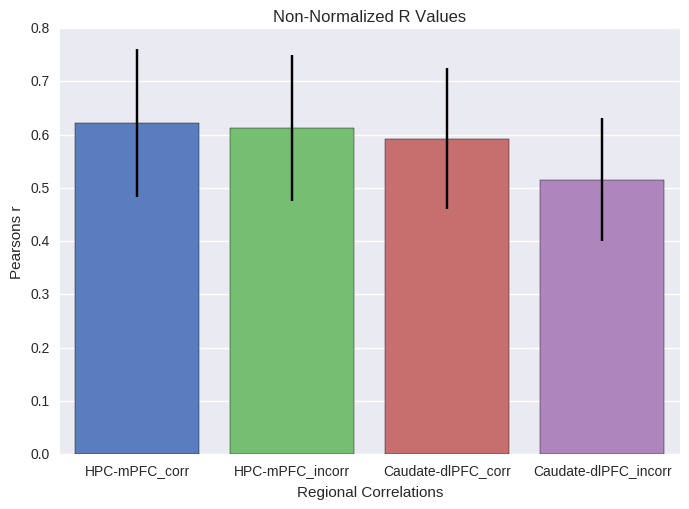

In [9]:
import seaborn as sns
#sns.set_style("ticks")
sns.set_palette('muted')
import matplotlib.pyplot as plt

N = 4
conditions = ['HPC-mPFC_corr', 'HPC-mPFC_incorr', 'Caudate-dlPFC_corr', 'Caudate-dlPFC_incorr']
means_allsubjs = [np.average(corr_chart['HPC-mPFC_corr']), 
                  np.average(corr_chart['HPC-mPFC_incorr']),
                  np.average(corr_chart['Caudate-dlPFC_corr']), 
                  np.average(corr_chart['Caudate-dlPFC_incorr'])]
sem_allsubjs = [np.average(corr_chart['HPC-mPFC_corr']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['HPC-mPFC_incorr']/(np.sqrt(len(sids)))),
                np.average(corr_chart['Caudate-dlPFC_corr']/(np.sqrt(len(sids)))), 
                np.average(corr_chart['Caudate-dlPFC_incorr']/(np.sqrt(len(sids))))]
print np.average(corr_chart['HPC-mPFC_corr'])
print np.average(corr_chart['HPC-mPFC_incorr'])
print np.average(corr_chart['Caudate-dlPFC_corr'])
print np.average(corr_chart['Caudate-dlPFC_incorr'])


ind = np.arange(N)
width = 0.5

fig, ax = plt.subplots()

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax = sns.barplot(ind, means_allsubjs, yerr = sem_allsubjs, ecolor = 'black')

ax.set_xticks(ind)
ax.set_xticklabels(conditions)
#ax.set_ylim(0,1)
ax.set_ylabel("Pearsons r")
ax.set_xlabel("Regional Correlations")
ax.set_title("Non-Normalized R Values")
plt.show()

## Normalized correlation matrix for beta series

In [7]:
# Use Numpy's arctangent function to normalize correlations
norm_corr = np.arctanh(corr_matrix[:, 1:])
#print(norm_corr)

In [8]:
import pandas as pd
norm_chart = {}
norm_chart['HPC-mPFC_corr'] = norm_corr[:, 0] #hpc-mpfc corr
norm_chart['HPC-mPFC_incorr'] = norm_corr[:, 1] #hpc-mpfc incorr
norm_chart['Caudate-dlPFC_corr'] = norm_corr[:, 2] #caudate-dlpfc corr
norm_chart['Caudate-dlPFC_incorr'] = norm_corr[:, 3] #caudate-dlpfc incorr
norm_chart_df = pd.DataFrame.from_dict(norm_chart)

In [9]:
norm_chart_df

,Caudate-dlPFC_corr,Caudate-dlPFC_incorr,HPC-mPFC_corr,HPC-mPFC_incorr
0,0.598474,0.264484,0.670434,0.411410
1,0.957151,0.933320,0.932299,1.172011
2,0.984677,0.841205,1.016815,0.663467
3,0.746804,0.367659,0.916044,0.639295
4,0.248931,0.530327,0.859962,1.310481
5,0.908447,0.859442,0.759597,0.875259
6,1.340050,1.285820,1.105613,1.028106
7,0.349985,0.233720,0.399434,0.464382
8,0.624254,0.712505,0.717827,0.569873
9,0.434676,0.220771,0.736207,0.885711


### Descriptive Statistics

In [10]:
print "Mean: HPC-mPFC_corr"
print np.average(norm_corr[:, 0])
print "SD: HPC-mPFC_corr"
print np.std(norm_corr[:, 0])
print ""
print "Mean: HPC-mPFC_incorr"
print np.average(norm_corr[:, 1])
print "SD: HPC-mPFC_incorr"
print np.std(norm_corr[:, 1])
print ""
print "Mean: Caudate-dlPFC_corr"
print np.average(norm_corr[:, 2])
print "SD: Caudate-dlPFC_corr"
print np.std(norm_corr[:, 2])
print ""
print "Mean: Caudate-dlPFC_incorr"
print np.average(norm_corr[:, 3])
print "SD: Caudate-dlPFC_incorr"
print np.std(norm_corr[:, 3])

Mean: HPC-mPFC_corr
0.768292140094
SD: HPC-mPFC_corr
0.262370644241

Mean: HPC-mPFC_incorr
0.776417443954
SD: HPC-mPFC_incorr
0.326787223466

Mean: Caudate-dlPFC_corr
0.735948717082
SD: Caudate-dlPFC_corr
0.316200738244

Mean: Caudate-dlPFC_incorr
0.630931690712
SD: Caudate-dlPFC_incorr
0.347393022762


### Inferential Statistics

In [11]:
print 'T-test: HPC-mPFC_corr vs. HPC-mPFC_incorr'
print stats.ttest_rel(norm_corr[:, 0], norm_corr[:, 1])
print ""

print 'T-test: Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr'
print stats.ttest_rel(norm_corr[:, 2], norm_corr[:, 3])
print ""

print "Bonferroni correction"
print '0.05/2 = 0.025'

T-test: HPC-mPFC_corr vs. HPC-mPFC_incorr
Ttest_relResult(statistic=-0.15759727802736015, pvalue=0.87643693796552591)

T-test: Caudate-dlPFC_corr vs. Caudate-dlPFC_incorr
Ttest_relResult(statistic=2.1950643526338363, pvalue=0.040784769919538291)

Bonferroni correction
0.05/2 = 0.025


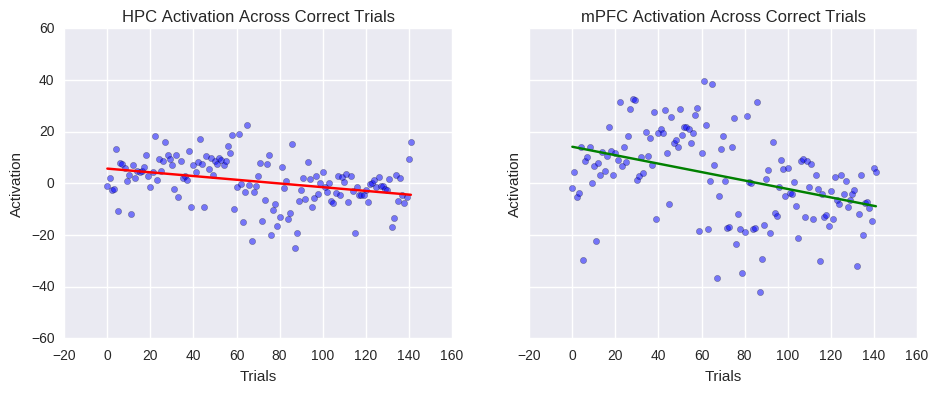

In [111]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,142,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_corr']
z = all_data['mPFC_corr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'red')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'green')
ax2.scatter(x, z, c = 'blue', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Correct Trials')

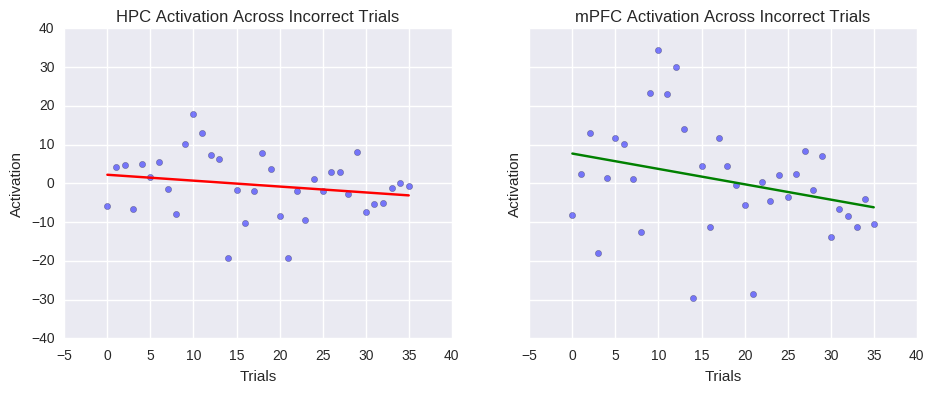

In [115]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,36,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['hp_incorr']
z = all_data['mPFC_incorr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'red')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('HPC Activation Across Incorrect Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'green')
ax2.scatter(x, z, c = 'blue', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('mPFC Activation Across Incorrect Trials')

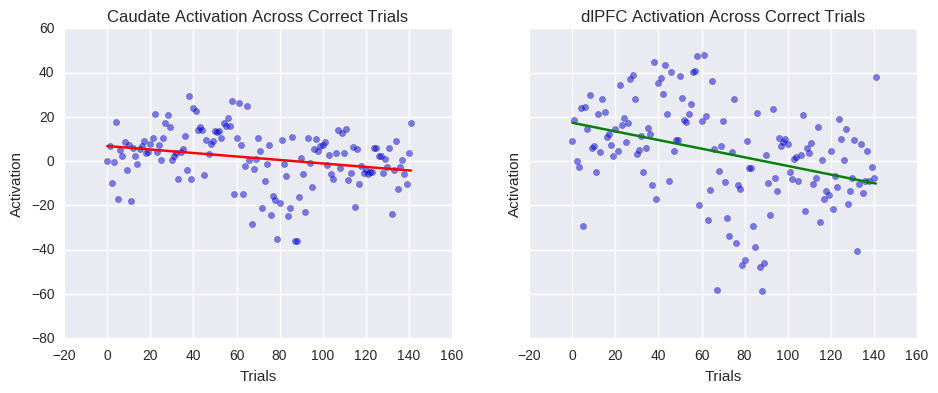

In [104]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,142,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_corr']
z = all_data['dlPFC_corr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'red')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Correct Trials')


fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'green')
ax2.scatter(x, z, c = 'blue', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Correct Trials')

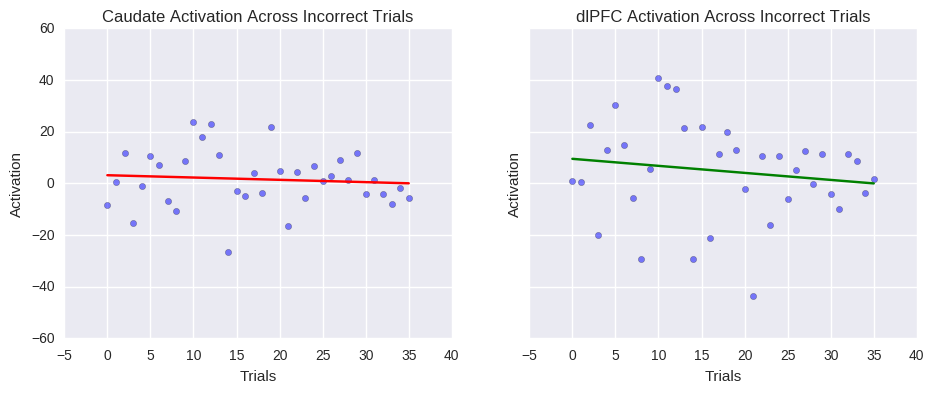

In [105]:
%matplotlib inline
# Scatterplot

ax = []
for a in range(0,36,1):
    ax.append(a)

x = ax

#print len(x)
y = all_data['caudate_incorr']
z = all_data['dlPFC_incorr']
#print len(y)
#print len(z)

fig, (ax, ax2) = plt.subplots(ncols = 2, figsize=(11, 4), sharex = True, sharey = True)
fit = np.polyfit(x, y, deg = 1)
ax.plot(x, np.array(fit[0]) * np.array(x) + np.array(fit[1]), color = 'red')
ax.scatter(x, y, c = 'blue', alpha = 0.5)
ax.set_ylabel('Activation')
ax.set_xlabel('Trials')
ax.set_title('Caudate Activation Across Incorrect Trials')

fit2 = np.polyfit(x, z, deg = 1)
ax2.plot(x, np.array(fit2[0]) * np.array(x) + np.array(fit2[1]), color = 'green')
ax2.scatter(x, z, c = 'blue', alpha = 0.5)
ax2.set_ylabel('Activation')
ax2.set_xlabel('Trials')
ax2.set_title('dlPFC Activation Across Incorrect Trials')